# Main Analysis

## Set Up

In [210]:
import os
os.getcwd()

PROJECT_ROOT = "/Users/bradykennedy/Documents/GitHub/ClassAndClimate"
os.chdir(PROJECT_ROOT)
print("Working directory set to:", os.getcwd())

Working directory set to: /Users/bradykennedy/Documents/GitHub/ClassAndClimate


In [211]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [212]:
FIG_DIR = Path("exports/figures")
TAB_DIR = Path("exports/tables")
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)


In [213]:
df = pd.read_csv("data/processed/analysis_model_2024.csv")

In [190]:
df["income_group"] = pd.Categorical(df["income_group"], ["low", "middle", "high"], ordered=True)
df["education_group"] = pd.Categorical(df["education_group"], ["hs_or_less", "some_college", "ba", "postgrad"], ordered=True)
df["age_group"] = pd.Categorical(df["age_group"], ["18_29", "30_44", "45_64", "65_plus"], ordered=True)

for c in ["pid7", "ideo5", "gender4", "race_eth"]:
    df[c] = df[c].astype("category")


In [191]:
df.isna().mean().sort_values(ascending=False).head(25)

homeowner                          0.063317
income_group                       0.000383
ideo5                              0.000217
renewables_20pct                   0.000083
halt_new_oil_gas_leases            0.000050
prevent_gas_stove_ban              0.000033
strengthen_epa_even_if_jobs        0.000033
epa_regulate_co2                   0.000033
support_fossil_fuel_expansion      0.000017
increase_fossil_fuel_production    0.000017
clean_energy_support               0.000017
caseid                             0.000000
race_eth                           0.000000
weight                             0.000000
gender4                            0.000000
age_group                          0.000000
age                                0.000000
education_group                    0.000000
pid7                               0.000000
n_index_items                      0.000000
dtype: float64

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   caseid                           60000 non-null  int64   
 1   weight                           60000 non-null  float64 
 2   pid7                             60000 non-null  category
 3   ideo5                            59987 non-null  category
 4   income_group                     59977 non-null  category
 5   education_group                  60000 non-null  category
 6   homeowner                        56201 non-null  float64 
 7   age                              60000 non-null  int64   
 8   age_group                        60000 non-null  category
 9   gender4                          60000 non-null  category
 10  race_eth                         60000 non-null  category
 11  clean_energy_support             59999 non-null  float64 
 12  supp

In [193]:
def wmean(x, w):
    x = pd.to_numeric(x, errors="coerce")
    w = pd.to_numeric(w, errors="coerce")
    mask = x.notna() & w.notna()
    return np.average(x[mask], weights=w[mask]) if mask.any() else np.nan

In [194]:
def wmean_by(df, y, by, w="weight"):
    d = df[[y, by, w]].copy()
    d[y] = pd.to_numeric(d[y], errors="coerce")
    d[w] = pd.to_numeric(d[w], errors="coerce")
    d = d.dropna(subset=[y, by, w])
    num = (d[y] * d[w]).groupby(d[by], observed=True).sum()
    den = d[w].groupby(d[by], observed=True).sum()
    out = (num / den).reset_index(name=f"wmean_{y}")
    return out

In [195]:
TERM_LABELS = {
    "homeowner": "Homeowner (vs renter)",

    "C(pid7, Treatment(reference=1))[T.2]": "Party ID: Lean Dem",
    "C(pid7, Treatment(reference=1))[T.3]": "Party ID: Independent",
    "C(pid7, Treatment(reference=1))[T.4]": "Party ID: Lean GOP",
    "C(pid7, Treatment(reference=1))[T.5]": "Party ID: Republican",
    "C(pid7, Treatment(reference=1))[T.6]": "Party ID: Strong GOP",
    "C(pid7, Treatment(reference=1))[T.7]": "Party ID: Other",
    "C(pid7, Treatment(reference=1))[T.8]": "Party ID: Nonresponse",


    "C(ideo5, Treatment(reference=1))[T.2.0]": "Ideology: Slightly liberal",
    "C(ideo5, Treatment(reference=1))[T.3.0]": "Ideology: Moderate",
    "C(ideo5, Treatment(reference=1))[T.4.0]": "Ideology: Conservative",
    "C(ideo5, Treatment(reference=1))[T.5.0]": "Ideology: Very conservative",
    "C(ideo5, Treatment(reference=1))[T.6.0]": "Ideology: Nonresponse",

    "C(income_group, Treatment(reference=\"low\"))[T.middle]": "Income: Middle",
    "C(income_group, Treatment(reference=\"low\"))[T.high]": "Income: High",

    "C(education_simple, Treatment(reference=\"hs_or_less\"))[T.some_college]": "Education: Some college",
    "C(education_simple, Treatment(reference=\"hs_or_less\"))[T.college_plus]": "Education: College+",

    "C(age_group, Treatment(reference=\"18_29\"))[T.30_44]": "Age: 30–44",
    "C(age_group, Treatment(reference=\"18_29\"))[T.45_64]": "Age: 45–64",
    "C(age_group, Treatment(reference=\"18_29\"))[T.65_plus]": "Age: 65+",

    "C(gender4, Treatment(reference=1))[T.2]": "Gender: Female",
    "C(gender4, Treatment(reference=1))[T.3]": "Gender: Nonbinary",
    "C(gender4, Treatment(reference=1))[T.4]": "Gender: Other",

    "C(race_eth, Treatment(reference=\"white_nonhisp\"))[T.black_nonhisp]": "Race: Black",
    "C(race_eth, Treatment(reference=\"white_nonhisp\"))[T.hispanic]": "Race: Hispanic",
    "C(race_eth, Treatment(reference=\"white_nonhisp\"))[T.other_nonhisp]": "Race: Other"
}


## Analysis

### Descriptive Stats

#### Clean energy support vs homeownership

In [196]:
wmean(df["clean_energy_support"], df["weight"])
wmean_by(df, "clean_energy_support", "pid7")
wmean_by(df, "clean_energy_support", "income_group")
wmean_by(df, "clean_energy_support", "homeowner")


,homeowner,wmean_clean_energy_support
0,0.0,0.700053
1,1.0,0.572429


#### Clean energy support vs homeownership & income group

In [197]:
d = df[["clean_energy_support", "income_group", "homeowner", "weight"]].dropna().copy()
d["wy"] = d["clean_energy_support"] * d["weight"]

num = d.groupby(["income_group", "homeowner"], observed=True)["wy"].sum()
den = d.groupby(["income_group", "homeowner"], observed=True)["weight"].sum()

table_inc_home = (num / den).reset_index(name="wmean_clean_energy_support")
table_inc_home


,income_group,homeowner,wmean_clean_energy_support
0,low,0.0,0.696416
1,low,1.0,0.588277
2,middle,0.0,0.704436
3,middle,1.0,0.566945
4,high,0.0,0.702988
5,high,1.0,0.569456


#### Plot Descriptive Stats

#### Clean energy support vs homeownership & income group

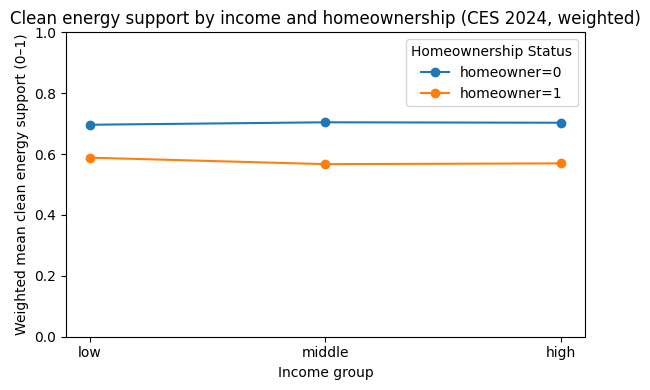

In [198]:
plot_df = table_inc_home.copy()

plot_df["income_group"] = pd.Categorical(
    plot_df["income_group"],
    categories=["low", "middle", "high"],
    ordered=True
)
plot_df = plot_df.sort_values(["homeowner", "income_group"])

fig, ax = plt.subplots(figsize=(6, 4))

for h in sorted(plot_df["homeowner"].unique()):
    sub = plot_df[plot_df["homeowner"] == h]
    ax.plot(sub["income_group"], sub["wmean_clean_energy_support"], marker="o", label=f"homeowner={int(h)}")

ax.set_xlabel("Income group")
ax.set_ylabel("Weighted mean clean energy support (0–1)")
ax.set_title("Clean energy support by income and homeownership (CES 2024, weighted)")
ax.set_ylim(0, 1)
ax.legend(title="Homeownership Status")

fig.tight_layout()
fig.savefig(FIG_DIR / "clean_energy_by_income_homeowner.png", dpi=200)
plt.show()
plt.close(fig)

### Inferential Stats

In [199]:
model_cols = [
    "clean_energy_support", "weight", "homeowner",
    "pid7", "ideo5", "income_group", "education_group",
    "age_group", "gender4", "race_eth"
]

m = df.dropna(subset=model_cols).copy()

m["education_simple"] = m["education_group"].astype(str).replace({
    "ba": "college_plus",
    "postgrad": "college_plus",
    "some_college": "some_college",
    "hs_or_less": "hs_or_less"
})
m["education_simple"] = pd.Categorical(
    m["education_simple"],
    categories=["hs_or_less", "some_college", "college_plus"],
    ordered=True
)

In [200]:
print("Rows before model dropna:", len(df))
print("Rows in model sample:", len(m))
print("Missing homeowner:", df["homeowner"].isna().mean())

Rows before model dropna: 60000
Rows in model sample: 56167
Missing homeowner: 0.06331666666666666


In [201]:
formula = """
clean_energy_support
~ homeowner
+ C(pid7, Treatment(reference=1))
+ C(ideo5, Treatment(reference=1))
+ C(income_group, Treatment(reference="low"))
+ C(education_simple, Treatment(reference="hs_or_less"))
+ C(age_group, Treatment(reference="18_29"))
+ C(gender4, Treatment(reference=1))
+ C(race_eth, Treatment(reference="white_nonhisp"))
"""

model_wls = smf.wls(
    formula=formula,
    data=m,
    weights=m["weight"]
).fit()

m_robust = model_wls.get_robustcov_results(cov_type="HC1") # Get robust SE

#print(m_robust.summary())

outdir_tables = Path("exports/tables")
with open(outdir_tables / "wls_summary.html", "w") as f:
    f.write(m_robust.summary().as_html())


In [202]:
terms = model_wls.model.exog_names
params = np.asarray(m_robust.params)
conf = np.asarray(m_robust.conf_int())

coef = pd.DataFrame({
    "term": terms,
    "estimate": params,
    "ci_low": conf[:, 0],
    "ci_high": conf[:, 1],
})

coef = coef[coef["term"] != "Intercept"].copy()
coef = coef.sort_values("estimate")

coef["label"] = coef["term"].map(TERM_LABELS)
coef["label"] = coef["label"].fillna(coef["term"])

missing = coef.loc[coef["label"] == coef["term"], "term"].tolist()
missing



[]

In [203]:
def block(term):
    if term.startswith("C(pid7"): return "Politics: Party ID"
    if term.startswith("C(ideo5"): return "Politics: Ideology"
    if term.startswith("C(income_group") or term.startswith("C(education_") or term=="homeowner":
        return "Class: Income / Education / Tenure"
    if term.startswith("C(age_group") or term.startswith("C(gender4") or term.startswith("C(race_eth"):
        return "Demographics"
    return "Other"

coef["block"] = coef["term"].apply(block)

reg_table = coef.copy()
reg_table["estimate"] = reg_table["estimate"].round(4)
reg_table["ci"] = reg_table.apply(lambda r: f"[{r['ci_low']:.4f}, {r['ci_high']:.4f}]", axis=1)

reg_table = (reg_table
    .sort_values(["block", "estimate"])
    [["block", "label", "estimate", "ci"]]
    .rename(columns={"block":"Block", "label":"Predictor", "estimate":"Coef (HC1)", "ci":"95% CI"})
)
reg_table

TAB_DIR = Path("exports/tables")
TAB_DIR.mkdir(parents=True, exist_ok=True)

html = (reg_table
        .style
        .hide(axis="index")
        .set_table_styles([{"selector": "th", "props": [("text-align", "left")]}])
        .to_html())

(TAB_DIR / "wls_table_labeled.html").write_text(html)

reg_table.head(30)

,Block,Predictor,Coef (HC1),95% CI
14,Class: Income / Education / Tenure,Income: High,-0.0307,"[-0.0441, -0.0174]"
26,Class: Income / Education / Tenure,Homeowner (vs renter),-0.0293,"[-0.0415, -0.0170]"
13,Class: Income / Education / Tenure,Income: Middle,-0.0084,"[-0.0211, 0.0043]"
15,Class: Income / Education / Tenure,Education: Some college,-0.0057,"[-0.0162, 0.0047]"
16,Class: Income / Education / Tenure,Education: College+,0.0111,"[-0.0012, 0.0233]"
22,Demographics,Gender: Other,-0.1325,"[-0.2397, -0.0253]"
19,Demographics,Age: 65+,-0.0621,"[-0.0796, -0.0447]"
18,Demographics,Age: 45–64,-0.0593,"[-0.0762, -0.0423]"
17,Demographics,Age: 30–44,-0.0314,"[-0.0489, -0.0139]"
23,Demographics,Race: Black,0.0143,"[-0.0024, 0.0311]"


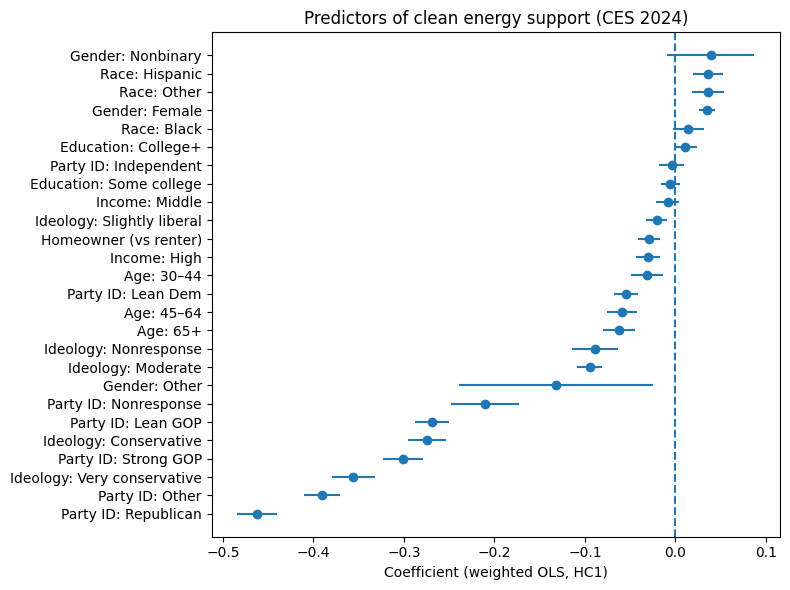

In [204]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    coef["estimate"],
    coef["label"],   # ← instead of coef["term"]
    xerr=[coef["estimate"] - coef["ci_low"], coef["ci_high"] - coef["estimate"]],
    fmt="o"
)
ax.axvline(0, linestyle="--")
ax.set_xlabel("Coefficient (weighted OLS, HC1)")
ax.set_ylabel("")
ax.set_title("Predictors of clean energy support (CES 2024)")

fig.tight_layout()
fig.savefig(FIG_DIR / "ols_coefplot.png", dpi=200)
plt.show()
plt.close(fig)

In [205]:
ref = {
    "pid7": int(m["pid7"].mode(dropna=True)[0]),
    "education_simple": "college_plus",
    "homeowner": 1,
    "age_group": "30_44",
    "gender4": int(m["gender4"].mode(dropna=True)[0]),
    "race_eth": "white_nonhisp",
}

ideo_vals = sorted([int(x) for x in m["ideo5"].dropna().unique()])

grid = []
for inc in ["low", "middle", "high"]:
    for ideo in ideo_vals:
        row = ref.copy()
        row.update({"income_group": inc, "ideo5": ideo})
        grid.append(row)

pred_df = pd.DataFrame(grid)
pred_df["pred"] = model_wls.predict(pred_df)
pred_df.head()

,pid7,education_simple,homeowner,age_group,gender4,race_eth,income_group,ideo5,pred
0,1,college_plus,1,30_44,2,white_nonhisp,low,1,0.995438
1,1,college_plus,1,30_44,2,white_nonhisp,low,2,0.974808
2,1,college_plus,1,30_44,2,white_nonhisp,low,3,0.900573
3,1,college_plus,1,30_44,2,white_nonhisp,low,4,0.720639
4,1,college_plus,1,30_44,2,white_nonhisp,low,5,0.639427


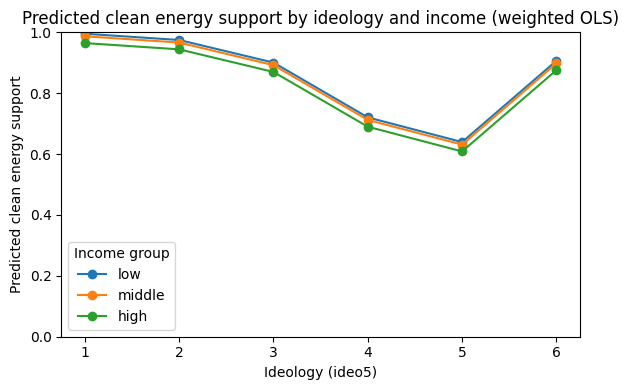

In [206]:
fig, ax = plt.subplots(figsize=(6, 4))

for inc in ["low", "middle", "high"]:
    sub = pred_df[pred_df["income_group"] == inc]
    ax.plot(sub["ideo5"], sub["pred"], marker="o", label=inc)

ax.set_xlabel("Ideology (ideo5)")
ax.set_ylabel("Predicted clean energy support")
ax.set_title("Predicted clean energy support by ideology and income (weighted OLS)")
ax.set_ylim(0, 1)
ax.legend(title="Income group")

fig.tight_layout()
fig.savefig(FIG_DIR / "predicted_support_ideo_income.png", dpi=200)
plt.show()
plt.close(fig)